intro di cosa faccio in questo notebook, e obiettivo

 Zillow is asking you to predict the log-error between their Zestimate and the actual sale price, given all the features of a home.

The log error is defined as

Zillow is asking us to predict the log-error between their Zestimate and the actual sale price, given all the features of a home.
`logerror = log(Zestimate) - log(SalePrice)`

and it is recorded in the transactions file train.csv.

To predict the sale prices of the houses and improve the log error i.e. the error due to the difference between the actual and the predicted home values.

In this competition, you are going to predict the logerror for the months in Fall 2017.  (penso fall 2017 dato che uso 2017, sept, oct, nov)

properties_2017.csv - all the properties with their home features for 2017 (released on 10/2/2017)
train_2017.csv - the training set with transactions from 1/1/2017 to 9/15/2017 (released on 10/2/2017)

Train/Test split

- You are provided with a full list of real estate properties in three counties (Los Angeles, Orange and Ventura, California) data in 2016.
- The train data has all the transactions before October 15, 2016, plus some of the transactions after October 15, 2016.
- The test data in the public leaderboard has the rest of the transactions between October 15 and December 31, 2016.
- The rest of the test data, which is used for calculating the private leaderboard, is all the properties in October 15, 2017, to December 15, 2017. This period is called the "sales tracking period", during which we will not be taking any submissions.
- You are asked to predict 6 time points for all properties: October 2016 (201610), November 2016 (201611), December 2016 (201612), October 2017 (201710), November 2017 (201711), and December 2017 (201712).
- Not all the properties are sold in each time period. If a property was not sold in a certain time period, that particular row will be ignored when calculating your score.
- If a property is sold multiple times within 31 days, we take the first reasonable value as the ground truth. By "reasonable", we mean if the data seems wrong, we will take the transaction that has a value that makes more sense.

# Introduction

In this notebook the datasets from the [Zillow Prize Challenge](https://www.kaggle.com/c/zillow-prize-1/overview) are elaborated with different levels of manual intervention in the feature engineering process, in order to understand how impactful each level of intervention is to the final model predictions.

Datasets are engineered in an incremental fashion, where level x+1 continues the engineering process from where the level x ended.

# Setup
Let us first import the necessary modules.

Importing the required libraries.

In [1]:
import numpy as np # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
import seaborn as sns # prolly non mi serve, e solo per estetica
import matplotlib.pyplot as plt

color = sns.color_palette() #di seaborn, se inutile tolgo
pd.set_option("display.max_columns", 100) #Display upto 100 columns
%matplotlib inline

# Might be needed in notebook to import modules
# dir structure: project -> src -> notebooks
import sys
import os
sys.path.insert(0, os.path.abspath("../../"))

from sklearn.ensemble import RandomForestRegressor

# sostituire se ho i file, sono solo per importare script python scritti da me
# import project.src.feat_engineering as fe
# import project.src.training as tr
# import project.src.visualization as vis
# import project.src.utils as utils
# import project.src.dataset_manager as dm

# RND_SEED = utils.RND_SEED #non so a cosa serva sinceramente
np.random.seed(1)

# Load Data

[>>>cambia testo<<<]
Only 2017 data is used since it is the updated version of 2016 and the two properties datasets do not differ significantly, except for some new properties that have their correct data registered.

reading the dataset.

We need to load the datasets that will be needed to train our machine learning algorithms, handle our data and make predictions.
Note that these datasets are the ones that are already provided once you enter the competition by accepting terms and conditions

In [2]:
# non so cosa sia actual # da pier
# ACTUAL_2017_CSV = f"{dm.DATASETS_DIR}/actual-2017.csv"
properties_2017 = pd.read_csv('../data/zillow-prize-1/properties_2017.csv')
train_2017 = pd.read_csv('../data/zillow-prize-1/train_2017.csv') #, parse_dates = ["transactiondate"] # loro lo fanno,pier?

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (49) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Property data

In [3]:
# Shape of the datasets
print('Shape of properties_2017: ', properties_2017.shape)
print('Shape of train_2017: ', train_2017.shape)

Shape of properties_2017:  (2985217, 58)
Shape of train_2017:  (77613, 3)


In [4]:
properties_2017.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34144442.0,-118654084.0,85768.0,NaN,NaN,NaN,NaN,NaN,010D,269.0,NaN,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,2016.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34140430.0,-118625364.0,4083.0,NaN,NaN,NaN,NaN,NaN,0109,261.0,LCA11*,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,5.0,NaN,NaN,NaN,NaN,73026.0,NaN,NaN,73026.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,33989359.0,-118394633.0,63085.0,NaN,NaN,NaN,NaN,NaN,1200,47.0,LAC2,6.037703e+07,51617.0,3101.0,NaN,96095.0,0.0,NaN,NaN,NaN,2.0,NaN,NaN,1959.0,1.0,NaN,660680.0,1434941.0,2016.0,774261.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,6.0,NaN,NaN,NaN,5068.0,NaN,NaN,5068.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34148863.0,-118437206.0,7521.0,NaN,NaN,NaN,NaN,NaN,1200,47.0,LAC2,6.037141e+07,12447.0,3101.0,27080.0,96424.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1948.0,1.0,NaN,580059.0,1174475.0,2016.0,594416.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,NaN,1776.0,NaN,NaN,1776.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34194168.0,-118385816.0,8512.0,NaN,NaN,NaN,NaN,NaN,1210,31.0,LAM1,6.037123e+07,12447.0,3101.0,46795.0,96450.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1947.0,1.0,NaN,196751.0,440101.0,2016.0,243350.0,5725.17,NaN,NaN,NaN


In [5]:
train_2017.head()

,parcelid,logerror,transactiondate
0,14297519,0.025595,2017-01-01
1,17052889,0.055619,2017-01-01
2,14186244,0.005383,2017-01-01
3,12177905,-0.103410,2017-01-01
4,10887214,0.006940,2017-01-01


Feature description:
<faccio lista delle feature>
vedo se serve
solo primo tizio lo fa

considerare rinominare le feature [exploratory in R](https://www.kaggle.com/code/philippsp/exploratory-analysis-zillow/report)
non ho preso altro da sto notebook dato che era tutto in R

# Unique and Duplicated values
(? è interessante sta parte, pensare se lasciarla, se lo fa anche pier)
andrebbe nella parte di analisi, o dopo target variable

Train data has some duplicate values, let's analyse those duplicate values to get better understanding.

In [6]:
def get_unique(name,data_series):   #non e molto utile ma ok ci penso
    print("{} has total {} records and {} are unique.".format(name,len(data_series),len(data_series.unique())))

In [7]:
get_unique("merged_df",train_2017["parcelid"])

merged_df has total 77613 records and 77414 are unique.


In [8]:
#da cancellare
duplicateRowsDF = train_2017[train_2017.duplicated(["parcelid"],keep=False)]
print("All Duplicate Rows based on all columns are :")
pd.DataFrame(duplicateRowsDF)

All Duplicate Rows based on all columns are :


,parcelid,logerror,transactiondate
116,11393337,0.015172,2017-01-03
117,11393337,0.086137,2017-06-08
624,14634203,-0.019491,2017-01-04
625,14634203,-0.061973,2017-08-04
1017,11721753,-0.011052,2017-01-05
...,...,...,...
63132,12136147,-0.078758,2017-08-31
64277,17282392,-0.002968,2017-08-07
64278,17282392,0.901074,2017-08-25
64943,10984080,0.001824,2017-08-09


In [9]:
#da cancellare
duplicateRowsDF["parcelid"].value_counts()

11991059    3
10857130    3
12612211    3
11393337    2
12892594    2
           ..
14079874    2
11401519    2
12607366    2
12532988    2
10984080    2
Name: parcelid, Length: 196, dtype: int64

In [10]:
#da cancellare
duplicateRowsDF.loc[duplicateRowsDF["parcelid"]==10857130]

,parcelid,logerror,transactiondate
44961,10857130,0.053244,2017-06-09
44962,10857130,0.053244,2017-06-30
44963,10857130,0.290908,2017-08-25


Here, we can observe that some houses were sold earlier in the year 2016 and after some month they were sold again in the same year. we will consider the last selling price of this type of house.

In [11]:
#da cancellare
# unique_train_data = train_2017.sort_values("transactiondate").drop_duplicates("parcelid",keep = "last")

In [12]:
# get_unique("unique_train_data",unique_train_data["parcelid"])

sta parte sopra bisogna vedere se pier la fa, come la gestisce

## poi fa Merging two dataset for modelling

In [13]:
# full_data = pd.DataFrame()
# full_data = pd.merge(properties_2017,unique_train_data,on="parcelid",how="left")

In [14]:
# get_unique("full_data",full_data["parcelid"])

In [15]:
# full_data["logerror"].value_counts().sum()

Removing all the rows with null values in target variable since they can not be used in model building.

In [16]:
# train_data = full_data[full_data["logerror"].notna()]
# len(train_data)

Dropping columns with missing value more than 30 percent.

poi droppa le colonne e fa linear regression prepotente
[reference](https://www.kaggle.com/code/runjiexia/zillow-price-linear-regression/edit)

## Get actually used property data
#### Observation:

The properties and target datasets are merged because a lot of properties in the first dataset aren't included in the second, which is the one that defines what data is necessary for the supervised learning.


We can see that parcelid is the unique identifier between the 2 tables. Therefore we will merge the 2 tables based on parcelid to form our complete datatset and then go ahead with other EDA techniques.



Merging of the two datasets
Understanding the dataset

In [17]:
# Reforming Dataset

merged_df = properties_2017.copy()
merged_df = merged_df.merge(train_2017,on = 'parcelid',how = 'inner')
merged_df.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate
0,17054981,NaN,NaN,NaN,5.0,4.0,NaN,NaN,5.0,NaN,1968.0,3760.0,3760.0,NaN,NaN,1968.0,NaN,6111.0,4.0,5.0,3.0,784.0,NaN,NaN,34449407.0,-119254052.0,42688.0,1.0,735.0,NaN,NaN,1.0,1110,261.0,NaN,6.111001e+07,13091.0,2061.0,NaN,97099.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,1982.0,2.0,NaN,501928.0,872850.0,2016.0,370922.0,9673.46,NaN,NaN,6.111001e+13,-0.013099,2017-06-15
1,17055743,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,66.0,1444.0,1444.0,1444.0,NaN,NaN,1444.0,NaN,6111.0,NaN,2.0,1.0,0.0,NaN,NaN,34454169.0,-119237898.0,7108.0,NaN,NaN,NaN,NaN,NaN,1110,261.0,NaN,6.111001e+07,13091.0,2061.0,NaN,97099.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,1951.0,1.0,NaN,130845.0,436157.0,2016.0,305312.0,5538.80,NaN,NaN,6.111001e+13,0.073985,2017-07-26
2,17068109,NaN,NaN,NaN,1.5,3.0,NaN,NaN,1.5,66.0,1698.0,1698.0,1698.0,NaN,NaN,1698.0,NaN,6111.0,1.0,1.0,0.0,0.0,NaN,NaN,34365693.0,-119448392.0,2588.0,NaN,NaN,NaN,NaN,NaN,1110,261.0,NaN,6.111001e+07,34543.0,2061.0,NaN,97081.0,6.0,NaN,1.0,NaN,NaN,NaN,NaN,1979.0,1.0,NaN,193413.0,286606.0,2016.0,93193.0,2987.36,NaN,NaN,6.111001e+13,0.071886,2017-07-28
3,17073952,NaN,NaN,NaN,2.0,2.0,NaN,NaN,2.0,NaN,986.0,986.0,986.0,NaN,NaN,986.0,NaN,6111.0,1.0,2.0,1.0,0.0,NaN,NaN,34305600.0,-119284000.0,NaN,NaN,NaN,NaN,NaN,NaN,1129,266.0,NaN,6.111002e+07,34543.0,2061.0,NaN,97081.0,4.0,NaN,NaN,NaN,NaN,55.0,NaN,1989.0,1.0,NaN,90357.0,258888.0,2016.0,168531.0,2706.24,NaN,NaN,6.111002e+13,0.305680,2017-06-02
4,17078502,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,1170.0,1170.0,1170.0,NaN,NaN,1170.0,NaN,6111.0,1.0,1.0,2.0,621.0,NaN,NaN,34278012.0,-119257047.0,5643.0,NaN,NaN,NaN,NaN,NaN,1110,261.0,NaN,6.111002e+07,34543.0,2061.0,NaN,97083.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,1948.0,1.0,NaN,148752.0,592930.0,2016.0,444178.0,6220.70,NaN,NaN,6.111002e+13,-0.073787,2017-07-07


In [18]:
merged_df.shape

(77613, 60)

# Saving the merged dataset

In [19]:
merged_df.to_csv('../data/starting_dataset_2017.csv', index=False)

anche quello del tizio crasto ha mergiato subito

In [20]:
 # Left join will ignore all properties that do not have a logerror (target variable) associated with them
# merged_2017 = pd.merge(train_2017, properties_2017, how = 'left', on = 'parcelid')

In [21]:
# print("Total Properties Shape: {}".format(quello_con_le_proprieta_non_train_e_non_merged.shape))
# print("-"*50)
# quello_merged.info()

**Observations based on the information above:**
               (sempre del notebook crasto)

- Total number of properties is 5.97 million, much smaller than the training dataset with transactions information for 335k entries
- Variable types distribution: 53 Float64, 6 Object (Categorical) and 1 Integer (ParcelID)
- Lots of variables contain missing data - these features are candidates for Imputation or Dropping.

In [22]:
# Check for and drop duplicates in training dataset
def check_duplicates(housing):
    idsUnique = len(housing[['parcelid', 'transactiondate']].value_counts())
    idsTotal = housing.shape[0]
    idsDupli = idsTotal - idsUnique
    print("There are " + str(idsDupli) + " duplicate IDs for " + str(idsTotal) + " total entries")

def drop_duplicates(housing):
    # Drop all duplicate entries which have the same parcelID and Transaction Date
    print("Dropping all duplicates based on parcelid and transactiondate...")
    return housing.drop_duplicates(subset=['parcelid', 'transactiondate'], keep='last', ignore_index=True)

In [23]:
# Check for and drop duplicates
check_duplicates(merged_df)
merged_df = drop_duplicates(merged_df)

# Validate
check_duplicates(merged_df)

There are 0 duplicate IDs for 77613 total entries
Dropping all duplicates based on parcelid and transactiondate...
There are 0 duplicate IDs for 77613 total entries


## Target data/Variable
preso da pier, a che serve?

Target variable for this competition is "logerror" field. So let us do some analysis on this field first. (notebook exploration)
`logerror` is the variable we need to predict. So let's do some analysis on this variable first.  (notebook crasto)

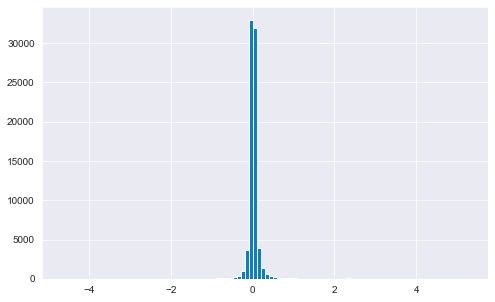

In [69]:
y = merged_df.logerror  #merged of train_2017 e lo stesso dato che prendo solo logerror
y.hist(bins=100, figsize=(8,5))
plt.show()

In [70]:
y.describe()

count    77613.000000
mean         0.016755
std          0.170887
min         -4.655420
25%         -0.024325
50%          0.006670
75%          0.039295
max          5.262999
Name: logerror, dtype: float64

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 0.02 and sigma = 0.17



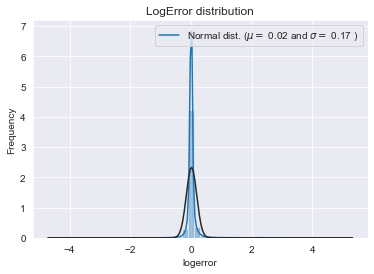

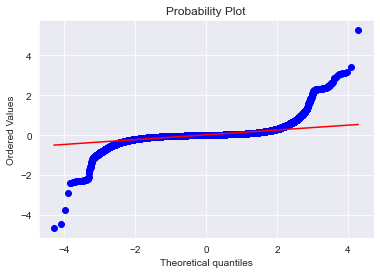

In [26]:
#wtf cosa fa
from scipy import stats
from scipy.stats import norm, skew #for some statistics

sns.distplot(y , fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(y)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
           loc='best')
plt.ylabel('Frequency')
plt.title('LogError distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(y, plot=plt)
plt.show()

The target variable is skewed and contains outliers. There are two options to treat this:

* For most cases, since (linear) models love normally distributed data, we would have transformed this variable through a log transformation to make it more normally distributed.
* However, given the unique nature of this specific problem where we are trying to predict the errors that the Zillow model makes when estimating house values, it makes more sense to ignore the cases where the Zillow model is horribly wrong - rather than try to learn the unique cases where it is way off.

target variable di exploration notebook

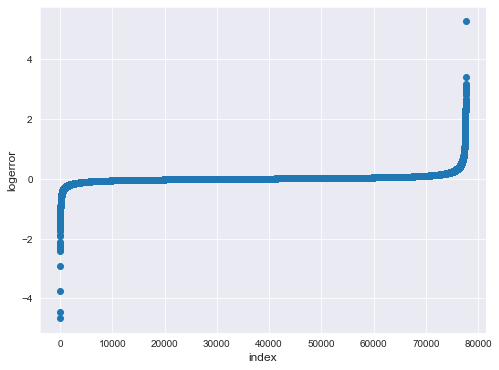

In [71]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_2017.shape[0]), np.sort(train_2017.logerror.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

This looks nice with some outliers at both the ends.!

Let us remove the outliers and then do a histogram plot on the same.

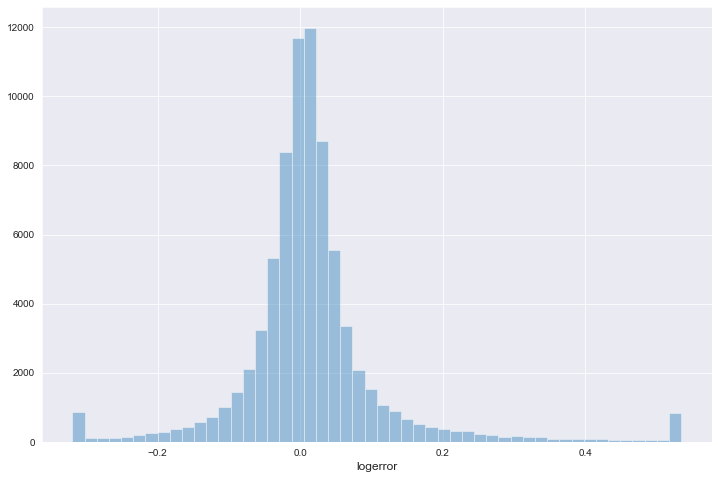

In [74]:
ulimit = np.percentile(train_2017.logerror.values, 99)
llimit = np.percentile(train_2017.logerror.values, 1)
train_2017['logerror'].loc[train_2017['logerror']>ulimit] = ulimit
train_2017['logerror'].loc[train_2017['logerror']<llimit] = llimit

plt.figure(figsize=(12,8))
sns.distplot(train_2017.logerror.values, bins=50, kde=False)
plt.xlabel('logerror', fontsize=12)
plt.show()

Wow. nice normal distribution on the log error.
(Warning: Starting in 0.20.0, the .ix indexer is deprecated, in favor of the more strict .iloc and .loc indexers)

poi sono tutti codici per vedere i dati dei dataset in [exploration](https://www.kaggle.com/code/runjiexia/simple-exploration-notebook-zillow-prize/edit)

## Exploratory Data Analysis (EDA)
(Data Visualization)  ------> da capire se roba sopra va sotto questa sezione

The reformed dataset contains 77613 rows and 60 columns.

Let's analyse the dataset to identify the following:

Missing values
Distribution of the numerical variables
Outliers
Distribution of the categorical variables
Potential relationship between the variables and the target


In [27]:
# Creating a copy of the dataset
house_df = merged_df.copy() #perche?

## Dataset Information:

In [28]:
merged_df.columns

Index(['parcelid', 'airconditioningtypeid', 'architecturalstyletypeid',
       'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertylandusetypeid',
       'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid',
       'unitcnt', 'yardbuildingsqft17', 'yardbuildin

In [29]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 60 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77613 non-null  int64  
 1   airconditioningtypeid         25007 non-null  float64
 2   architecturalstyletypeid      207 non-null    float64
 3   basementsqft                  50 non-null     float64
 4   bathroomcnt                   77579 non-null  float64
 5   bedroomcnt                    77579 non-null  float64
 6   buildingclasstypeid           15 non-null     float64
 7   buildingqualitytypeid         49809 non-null  float64
 8   calculatedbathnbr             76963 non-null  float64
 9   decktypeid                    614 non-null    float64
 10  finishedfloor1squarefeet      6037 non-null   float64
 11  calculatedfinishedsquarefeet  77378 non-null  float64
 12  finishedsquarefeet12          73923 non-null  float64
 13  f

In [30]:
merged_df.describe()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock,logerror
count,7.761300e+04,25007.000000,207.000000,50.000000,77579.000000,77579.000000,15.000000,49809.000000,76963.000000,614.0,6037.000000,77378.000000,73923.000000,42.000000,3027.000000,6037.000000,386.000000,77579.000000,8289.000000,76963.000000,25520.000000,25520.000000,49571.000000,7.757900e+04,7.757900e+04,6.932100e+04,16174.0,869.000000,465.0,1074.0,15079.0,77579.000000,7.757900e+04,76107.000000,77579.000000,30974.000000,77529.000000,77579.000000,50.0,10106.000000,223.000000,50703.000000,2393.000000,70.000000,77309.000000,17599.000000,7.746400e+04,7.757800e+04,77579.0,7.757700e+04,77574.000000,2900.000000,7.733200e+04,77613.000000
mean,1.300781e+07,1.812013,7.386473,679.720000,2.298496,3.053223,3.933333,6.533779,2.316392,66.0,1366.165314,1784.935421,1760.284553,1388.761905,2354.491245,1381.388935,2082.500000,6048.814151,1.191217,2.250107,1.815282,350.047061,3.921749,3.400837e+07,-1.182037e+08,2.997344e+04,1.0,517.930955,1.0,1.0,1.0,261.824476,6.049124e+07,33683.055107,2534.514933,187725.110544,96586.692812,1.476276,7.0,1.009598,6.040359,1.110309,305.460928,216.385714,1968.611507,1.434286,1.892811e+05,4.901506e+05,2016.0,3.011515e+05,5995.961788,14.088276,6.049667e+13,0.016755
std,3.518717e+06,2.965768,2.728030,689.703546,0.996732,1.140480,0.258199,1.722062,0.979689,0.0,670.701336,954.250373,934.352566,122.220874,1186.985442,725.792665,1240.382784,20.747252,0.490980,0.966492,0.588340,261.646070,3.594780,2.652873e+05,3.594085e+05,1.233050e+05,0.0,156.569664,0.0,0.0,0.0,5.141596,2.058962e+05,47211.780350,801.447913,165045.086058,3793.552065,2.823686,0.0,0.118572,0.556035,1.169967,238.735241,190.177514,23.793171,0.544515,2.304107e+05,6.537979e+05,0.0,4.927249e+05,7628.859728,2.181281,1.533339e+12,0.170887
min,1.071186e+07,1.000000,2.000000,38.000000,0.000000,0.000000,3.000000,1.000000,1.000000,66.0,44.000000,128.000000,128.000000,1056.000000,598.000000,44.000000,380.000000,6037.000000,1.000000,1.000000,0.000000,0.000000,1.000000,3.333953e+07,-1.194754e+08,2.360000e+02,1.0,24.000000,1.0,1.0,1.0,31.000000,6.037101e+07,3491.000000,1286.000000,6952.000000,95982.000000,0.000000,7.0,1.000000,4.000000,1.000000,11.000000,12.000000,1824.000000,1.000000,4.400000e+01,1.000000e+03,2016.0,1.610000e+02,19.920000,3.000000,6.037101e+13,-4.655420
25%,1.153821e+07,1.000000,7.000000,273.000000,2.000000,2.000000,4.000000,6.000000,2.000000,66.0,955.000000,1182.000000,1172.000000,1344.000000,1624.000000,956.000000,993.750000,6037.000000,1.000000,2.000000,2.000000,0.000000,2.000000,3.381463e+07,-1.184150e+08,5.700000e+03,1.0,424.000000,1.0,1.0,1.0,261.000000,6.037311e+07,12447.000000,1286.000000,46736.000000,96193.000000,0.000000,7.0,1.000000,6.000000,1.000000,170.000000,61.500000,1953.000000,1.000000,8.417925e+04,2.068985e+05,2016.0,8.529300e+04,2712.630000,14.000000,6.037311e+13,-0.024325
50%,1.253004e+07,1.000000,7.000000,515.000000,2.000000,3.000000,4.000000,6.000000,2.000000,66.0,1257.000000,1542.000000,1523.000000,1440.000000,2088.000000,1259.000000,1812.500000,6037.000000,1.000000,2.000000,2.000000,436.000000,2.000000,3.402200e+07,-1.181810e+08,7.206000e+03,1.0,500.000000,1.0,1.0,1.0,2

### Missing values
Checking for Missing values

In [31]:
mis_val = [var for var in merged_df.columns if merged_df[var].isnull().sum()>0]
# print(mis_val)  #dovrebbero essere le colonne che contengono null value
merged_df[mis_val].isnull().sum()

airconditioningtypeid           52606
architecturalstyletypeid        77406
basementsqft                    77563
bathroomcnt                        34
bedroomcnt                         34
buildingclasstypeid             77598
buildingqualitytypeid           27804
calculatedbathnbr                 650
decktypeid                      76999
finishedfloor1squarefeet        71576
calculatedfinishedsquarefeet      235
finishedsquarefeet12             3690
finishedsquarefeet13            77571
finishedsquarefeet15            74586
finishedsquarefeet50            71576
finishedsquarefeet6             77227
fips                               34
fireplacecnt                    69324
fullbathcnt                       650
garagecarcnt                    52093
garagetotalsqft                 52093
hashottuborspa                  76074
heatingorsystemtypeid           28042
latitude                           34
longitude                          34
lotsizesquarefeet                8292
poolcnt     

In [32]:
print("Total no of variables with missing value in the dataset: ", len(mis_val))

Total no of variables with missing value in the dataset:  57


In [33]:
# Missing Values Percentage in total data (tutto il dataset)
merged_df.isnull().mean()*100

parcelid                         0.000000
airconditioningtypeid           67.779882
architecturalstyletypeid        99.733292
basementsqft                    99.935578
bathroomcnt                      0.043807
bedroomcnt                       0.043807
buildingclasstypeid             99.980673
buildingqualitytypeid           35.823895
calculatedbathnbr                0.837489
decktypeid                      99.208895
finishedfloor1squarefeet        92.221664
calculatedfinishedsquarefeet     0.302784
finishedsquarefeet12             4.754358
finishedsquarefeet13            99.945885
finishedsquarefeet15            96.099880
finishedsquarefeet50            92.221664
finishedsquarefeet6             99.502661
fips                             0.043807
fireplacecnt                    89.320088
fullbathcnt                      0.837489
garagecarcnt                    67.118910
garagetotalsqft                 67.118910
hashottuborspa                  98.017085
heatingorsystemtypeid           36

Relationship between missing values and log error (Target Variable)

In [34]:
def analyze_missing_values(df, var):   # non capisco esattamente cosa stampino quei grafici ?????
    new_df = df.copy()

    new_df[var] = np.where(new_df[var].isnull(), 1, 0)
    # here 1 represents that there is missing value and 0 represents no missing values

    new_df.groupby(var)['logerror'].median().plot.bar()

    plt.title(var)
    plt.show()

In [35]:
# for var in mis_val:
#     analyze_missing_values(merged_df, var)

non so se servano
(del primo tizio)

## Distribution of Numerical variables

In [36]:
num_vars = [var for var in merged_df.columns if merged_df[var].dtypes!= 'O'] # Non-Object Variables
print("Total no.of numerical variables in the dataset: ", len(num_vars))

Total no.of numerical variables in the dataset:  54


In [37]:
merged_df[num_vars].head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock,logerror
0,17054981,NaN,NaN,NaN,5.0,4.0,NaN,NaN,5.0,NaN,1968.0,3760.0,3760.0,NaN,NaN,1968.0,NaN,6111.0,4.0,5.0,3.0,784.0,NaN,34449407.0,-119254052.0,42688.0,1.0,735.0,NaN,NaN,1.0,261.0,6.111001e+07,13091.0,2061.0,NaN,97099.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,1982.0,2.0,501928.0,872850.0,2016.0,370922.0,9673.46,NaN,6.111001e+13,-0.013099
1,17055743,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,66.0,1444.0,1444.0,1444.0,NaN,NaN,1444.0,NaN,6111.0,NaN,2.0,1.0,0.0,NaN,34454169.0,-119237898.0,7108.0,NaN,NaN,NaN,NaN,NaN,261.0,6.111001e+07,13091.0,2061.0,NaN,97099.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,1951.0,1.0,130845.0,436157.0,2016.0,305312.0,5538.80,NaN,6.111001e+13,0.073985
2,17068109,NaN,NaN,NaN,1.5,3.0,NaN,NaN,1.5,66.0,1698.0,1698.0,1698.0,NaN,NaN,1698.0,NaN,6111.0,1.0,1.0,0.0,0.0,NaN,34365693.0,-119448392.0,2588.0,NaN,NaN,NaN,NaN,NaN,261.0,6.111001e+07,34543.0,2061.0,NaN,97081.0,6.0,NaN,1.0,NaN,NaN,NaN,NaN,1979.0,1.0,193413.0,286606.0,2016.0,93193.0,2987.36,NaN,6.111001e+13,0.071886
3,17073952,NaN,NaN,NaN,2.0,2.0,NaN,NaN,2.0,NaN,986.0,986.0,986.0,NaN,NaN,986.0,NaN,6111.0,1.0,2.0,1.0,0.0,NaN,34305600.0,-119284000.0,NaN,NaN,NaN,NaN,NaN,NaN,266.0,6.111002e+07,34543.0,2061.0,NaN,97081.0,4.0,NaN,NaN,NaN,NaN,55.0,NaN,1989.0,1.0,90357.0,258888.0,2016.0,168531.0,2706.24,NaN,6.111002e+13,0.305680
4,17078502,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,1170.0,1170.0,1170.0,NaN,NaN,1170.0,NaN,6111.0,1.0,1.0,2.0,621.0,NaN,34278012.0,-119257047.0,5643.0,NaN,NaN,NaN,NaN,NaN,261.0,6.111002e+07,34543.0,2061.0,NaN,97083.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,1948.0,1.0,148752.0,592930.0,2016.0,444178.0,6220.70,NaN,6.111002e+13,-0.073787


## Distribution of Categorical variables

In [38]:
cat_vars = [var for var in merged_df.columns if merged_df[var].dtypes == 'O'] # Object Variables
print("Total no.of categorical variables in the dataset: ", len(cat_vars))

Total no.of categorical variables in the dataset:  6


In [39]:
merged_df[cat_vars].head()

,hashottuborspa,propertycountylandusecode,propertyzoningdesc,fireplaceflag,taxdelinquencyflag,transactiondate
0,NaN,1110,NaN,NaN,NaN,2017-06-15
1,NaN,1110,NaN,NaN,NaN,2017-07-26
2,NaN,1110,NaN,NaN,NaN,2017-07-28
3,NaN,1129,NaN,NaN,NaN,2017-06-02
4,NaN,1110,NaN,NaN,NaN,2017-07-07


In [40]:
for var in cat_vars:
    print(var,'-->', len(merged_df[var].unique()), "Categories")

hashottuborspa --> 2 Categories
propertycountylandusecode --> 76 Categories
propertyzoningdesc --> 1908 Categories
fireplaceflag --> 2 Categories
taxdelinquencyflag --> 2 Categories
transactiondate --> 264 Categories


In [41]:
### Analyzing Rarely occuring Labels

def analyze_rare_labels(df, var, rare_percentage):
    new_df = df.copy()

    # determine the % of observations per category
    tmp = new_df.groupby(var)['logerror'].count() / len(new_df)

    # return categories that are rare
    return tmp[tmp < rare_percentage]

In [42]:
# print categories that are present in less than 1% of the observations    #??????????
for var in cat_vars:
    print(analyze_rare_labels(merged_df, var, 0.01))
    print()

Series([], Name: logerror, dtype: float64)

propertycountylandusecode
0102    0.000039
0103    0.001172
0104    0.004754
0105    0.000039
0108    0.000734
          ...   
1720    0.000090
1722    0.000026
38      0.001211
73      0.000116
96      0.001172
Name: logerror, Length: 63, dtype: float64

propertyzoningdesc
1NR1*         0.000064
1NR3*         0.000039
AH RM-CD*     0.000064
AH RM-CD-F    0.000013
AH RS-(3)-    0.000013
                ...   
WVRPD40000    0.000013
WVRPD4OOOO    0.000103
WVRPD56*      0.000039
WVRR          0.000026
WVRR1-RPD1    0.000052
Name: logerror, Length: 1899, dtype: float64

fireplaceflag
True    0.002216
Name: logerror, dtype: float64

Series([], Name: logerror, dtype: float64)

transactiondate
2017-01-01    0.000103
2017-01-02    0.001237
2017-01-03    0.003865
2017-01-04    0.004110
2017-01-05    0.005102
                ...   
2017-09-18    0.002268
2017-09-19    0.003517
2017-09-20    0.000026
2017-09-21    0.000026
2017-09-25    0.000013
Name:

#### Temporal variables assosciated with time

In [43]:
year_var = [var for var in num_vars if 'Yr' in var or 'year' in var ]
len(year_var), year_var

(3, ['yearbuilt', 'assessmentyear', 'taxdelinquencyyear'])

#### Relationship between Temporal variables and Log error

Text(0.5, 1.0, 'Year Difference vs Logerror')

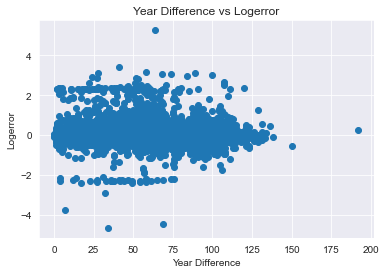

In [44]:
new_df = merged_df.copy()

# Difference between year variable and year the house was sold
new_df[var] = new_df['assessmentyear'] - new_df['yearbuilt']

plt.scatter(new_df[var],new_df['logerror'])
plt.xlabel('Year Difference')
plt.ylabel('Logerror')
plt.title('Year Difference vs Logerror')

## Distribution of Discrete variables

In [45]:
discrete_vars = [var for var in num_vars if len(merged_df[var].unique()) < 20]

print('No.of discrete variables: ', len(discrete_vars))

No.of discrete variables:  26


In [46]:
merged_df[discrete_vars].head()

,airconditioningtypeid,architecturalstyletypeid,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,decktypeid,finishedsquarefeet13,fips,fireplacecnt,fullbathcnt,garagecarcnt,heatingorsystemtypeid,poolcnt,pooltypeid10,pooltypeid2,pooltypeid7,propertylandusetypeid,regionidcounty,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,numberofstories,assessmentyear,taxdelinquencyyear
0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,6111.0,4.0,5.0,3.0,NaN,1.0,NaN,NaN,1.0,261.0,2061.0,11.0,NaN,NaN,NaN,NaN,2.0,2016.0,NaN
1,NaN,NaN,3.0,NaN,NaN,66.0,NaN,6111.0,NaN,2.0,1.0,NaN,NaN,NaN,NaN,NaN,261.0,2061.0,6.0,NaN,NaN,NaN,NaN,1.0,2016.0,NaN
2,NaN,NaN,3.0,NaN,NaN,66.0,NaN,6111.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,261.0,2061.0,6.0,NaN,1.0,NaN,NaN,1.0,2016.0,NaN
3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,6111.0,1.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,266.0,2061.0,4.0,NaN,NaN,NaN,NaN,1.0,2016.0,NaN
4,NaN,NaN,2.0,NaN,NaN,NaN,NaN,6111.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,261.0,2061.0,5.0,NaN,NaN,NaN,NaN,1.0,2016.0,NaN


In [47]:
def analyze_disc_vars(df,var):

    new_df = merged_df.copy()
    new_df[var].hist(bins=20)
    plt.xlabel(var)
    plt.ylabel('Count')
    plt.title('Variation of '+ var)
    plt.show()

In [48]:
# for var in discrete_vars:
#     analyze_disc_vars(merged_df,var)

## Distribution of Continuous variables

In [49]:
cont_vars = [var for var in num_vars if var not in discrete_vars and year_var]
print('No of continuous variables : ', len(cont_vars))

No of continuous variables :  28


In [50]:
def analyze_cont_vars(df,var):

    new_df = merged_df.copy()
    new_df[var].hist(bins=20)
    plt.xlabel(var)
    plt.ylabel('Count')
    plt.title('Variation of '+ var)
    plt.show()

In [51]:
# for var in cont_vars:
#     analyze_cont_vars(merged_df,var)

## Observation:

Some of the variables are not normally distributed.

Evaluate if a logarithmic transformation of the variables returns values that will follow normal distribution

In [52]:
# log Transformation of variables

def analyze_log_variation(df,var):

    new_df = df.copy()
    if 0 in new_df[var].unique():
        pass
        # Hence log(0) = undefined

    else:

        new_df[var] = np.log(new_df[var])
        new_df[var].hist(bins=20)
        plt.xlabel(var)
        plt.ylabel('Count')
        plt.title('Logarithmic Variation of '+ var)
        plt.show()

In [61]:
# for var in cont_vars:
#     analyze_log_variation(merged_df,var)

## Observation:

We see that we get a better spread of the values for only few variables when we use the logarithmic transformation.

## Analyzing Outliers

In [54]:
def analyze_outliers(df,var):

    new_df = df.copy()

    if 0 in new_df[var].unique():
        pass

    else:
        new_df[var] = np.log(df[var])
        new_df.boxplot(column=var)
        plt.tight_layout()
        plt.show()

In [55]:
# for var in cont_vars:
#     analyze_outliers(merged_df,var)
#     print('\n')

## Observation:

We can see that there are outliers in some of the variables and we will remove those outliers with feature engineering and bulid a model on top of it

da [notebook crasto](https://www.kaggle.com/code/devanshm/zillow-end-to-end-ml-workflow-top-250-0-06416/notebook)

## Dropping Outliers

Since the data is mostly normally distributed outside of the outliers, we will drop all values that are more than 2.5 standard deviations away from the mean. For reference, for the standard normal distribution, 68% of the observations lie within 1 standard deviation of the mean; 95% lie within two standard deviation of the mean; and 99.9% lie within 3 standard deviations of the mean.

In [56]:
highest_thres = y.mean() + 2.5*y.std()
lowest_thres = y.mean() - 2.5*y.std()
print("Highest allowed",highest_thres)
print("Lowest allowed", lowest_thres)

Highest allowed 0.44397321398406825
Lowest allowed -0.41046332696829874


In [57]:
# Only the training set outliers will be dropped (not validation or testing set to ensure model performs well on outliers too)
y = y[y > lowest_thres]
y = y[y < highest_thres]

# Update original Housing dataframe
housing = merged_df[merged_df.logerror > lowest_thres]
housing = housing[housing.logerror < highest_thres]

In [58]:
# Drop rows containing either 75% or more NaN Values
percent = 75.0
min_count =  int(((100-percent)/100)*housing.shape[1] + 1)
housing = housing.dropna(axis=0, thresh=min_count)
housing.shape

(76059, 60)

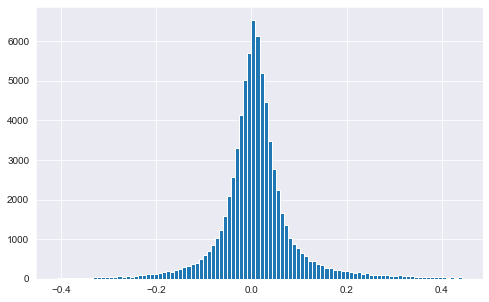

In [59]:
y.hist(bins=100, figsize=(8,5))
plt.show()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 0.01 and sigma = 0.08



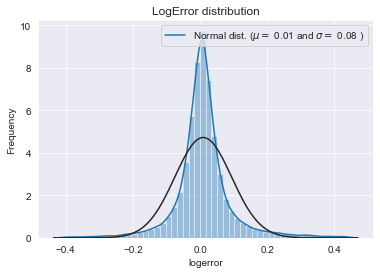

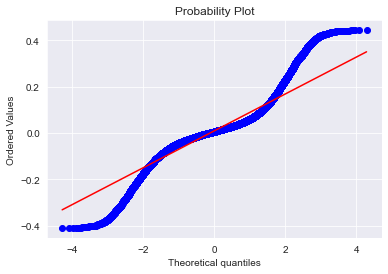

In [60]:
#Check the new distribution
sns.distplot(y , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(y)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
           loc='best')
plt.ylabel('Frequency')
plt.title('LogError distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(y, plot=plt)
plt.show()

The skew seems now corrected and the data appears better normally distributed.

next part is Create Test/Train datasets (per feat eng penso)

.








.

# Feature Engineering

a.Duplicate value removal

b.Missing value imputation

c.Rescaling of incorrectly scaled data

d.Standardization

e.Encoding of categorical variables

f.Generation of new feature wherever required.

g.Dropping of redundant feature columns

h.Checking for multi-collinearity and removal of highly correlated features

i.Check for the outliners and removal of outliers.

### Correlations

### Store into .csv

Storing this dataframe in a separate .csv will come handy for later tasks.
logerror and transactiondate are dropped because they are not property data.